# RAG Agent

Retrieval Augmented Generation (RAG) is one of the most useful applications of AI agents. 

It consists in grounding the answers of our agent to a given knowledge base, that our agent can access by using tools.

This knowledge base - i.e., our collection of documents - is embedded in a vector store for efficient search. 

This method prevents allucinations and highly increases the accuracy of the agentic system.

Steps in this implementation:

1. get a knowledge base: we do that manually, and for this example we use only one document for simplicity. 

2. perform OCR of our documents to best extract information;

3. embed our documents in a vector database (vector store)

4. construct a tool for searching in the database

5. create the graph with grading and retries. 

## 1. Knowledge Base

We selected scientific papers on the topic on the topic **"LLM-Agents for Urban Mobility & Traffic Engineering"**.

We stored them in the folder `documents/`.

## 2. OCR (Optical Character Recognition)

As we said, we usually need to perform OCR on a knowledge based composed by documents. 

>Notice that we may skip this step if our knowledge base is already composed of plain text (for example, this could happen if our base is made thorugh web scarping, which usually returns plain text or markdown).

In this case our papers are complex, and contain mathematical expressions, tables, images. OCR is not a simple/skippable step here. 

That's why we are going to user the best OCR model around this days (January 2026): Mistral OCR 3. Find a usage example in the [mistral_ocr](./mistral_ocr.ipynb) notebook, and a full example from the actual Mistral site here: [link](https://colab.research.google.com/github/mistralai/cookbook/blob/main/mistral/ocr/data_extraction.ipynb). 

The latter showcases how to use their `Annotations` API to also annotate the detected bounding boxes. We will use this feature to include images in our RAG pipeline. 

> **Note:** You can replace Mistral's OCR API with a free process provided by LangChain, using `PyMuPDF4LLM` and the `Upstage Document Parse API`. Results will not be as good as using Mistral but probably will be good enough for many applications (and it's all free). Check the full tutorial here: [Multimodal RAG tutorial](https://langchain-opentutorial.gitbook.io/langchain-opentutorial/19-cookbook/06-multimodal/10-geminimultimodalrag#layout-parsing-to-extract-image-from-pdf-using-upstage-document-parse-api). 

### 2.1 Mistral OCR with Annotations

Mistral Document AI API adds two annotation functionalities:

- `document_annotation`: returns the annotation of the entire document based on the input schema.
- `box_annotation`: gives you the annotation of the bboxes extracted by the OCR model (charts/ figures etc) based on user requirement. The user may ask to describe/caption the figure for instance.

In [3]:
%pip install -q -U mistralai 

Note: you may need to restart the kernel to use updated packages.


Function to encode in base 64:

In [4]:
import base64

def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None

In [7]:
base64_pdf = encode_pdf("RAG/documents/KimiK2.pdf")

First, we need to create our Annotation Formats, for that we advise make use of pydantic.

For this example, we will extract the image type and a description of each bbox; as well as the language, authors and a summary of the full document.

In [67]:
from pydantic import BaseModel, Field
from enum import Enum

class ImageType(str, Enum):
    GRAPH = "graph"
    TEXT = "text"
    TABLE = "table"
    IMAGE = "image"

class Image(BaseModel):
    image_type: ImageType = Field(..., description="The type of the image. Must be one of 'graph', 'text', 'table' or 'image'.")
    description: str = Field(..., description="A description of the image.")

class Document(BaseModel):
    summary: str = Field(..., description="A summary of the document.")
    authors: list[str] = Field(..., description="A list of authors who contributed to the document.")

Now with our pydantic models created for our Annotations, we can call our OCR endpoint.

The objective is to Annotate and Extract information from our document and the bbox/images detected.

In [68]:
from mistralai.extra import response_format_from_pydantic_model
from dotenv import load_dotenv
import os
import json

# Initialize Mistral client with API key
from mistralai import Mistral
load_dotenv()
client = Mistral(api_key=os.getenv("MISTRAL_API_KEY"))

# OCR Call with Annotations
annotations_response = client.ocr.process(
    model="mistral-ocr-latest",
    pages=list(range(16, 24)), # Document Annotations has a limit of 8 pages, we recommend spliting your documents when using it; bbox annotations does not have the same limit
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_pdf}"
    },
    bbox_annotation_format=response_format_from_pydantic_model(BBox),
    document_annotation_format=response_format_from_pydantic_model(Document),
    include_image_base64=True, # Let's also include the images in the response
    table_format="html"
  )

# Convert response to JSON format
response_dict = json.loads(annotations_response.model_dump_json())

print(json.dumps(response_dict, indent=4))

{
    "pages": [
        {
            "index": 16,
            "markdown": "##### Agentic Tool Use\n\nOn multi-turn tool-use benchmarks, Kimi-K2-Instruct sets a new standard. It achieves 66.1 Pass@1 on $\\tau^{2}$-Bench and 76.5 on ACEBench, substantially outperforming all baselines. These results affirm its strength in grounded, controlled, and agent-driven tool orchestration across domains.\n\n##### General Capabilities\n\nKimi-K2-Instruct exhibits strong, balanced performance across general knowledge, math, instruction following, and long-context tasks. It surpasses open-source peers on SimpleQA (31.0%), MMLU (89.5%) and MMLU-Redux (92.7%), and leads all models on instruction benchmarks (IFEval: 89.8%, Multi-Challenge: 54.1%). In math and STEM, it achieves top-tier scores (AIME 2024: 69.6%, GPQA-Diamond: 75.1%), and remains competitive on long-context factuality and retrieval (DROP: 93.5%, MRCR: 55.0%). These results position Kimi-K2-Instruct as a well-rounded and capable generalis

Let's split the pdf into 8 pages batches first as they advice to do:

In [11]:
%pip install -q -U pypdf

Note: you may need to restart the kernel to use updated packages.


In [43]:
from pypdf import PdfReader, PdfWriter

def split_pdf(input_path, chunk_size=8, output_dir="RAG/documents/chunks"):
    os.makedirs(output_dir, exist_ok=True)
    reader = PdfReader(input_path)
    for i in range(0, len(reader.pages), chunk_size):
        writer = PdfWriter()
        for page in reader.pages[i : i + chunk_size]:
            writer.add_page(page)
        
        chunk_filename = f"chunk_{i//chunk_size}.pdf"
        chunk_path = os.path.join(output_dir, chunk_filename)
        with open(chunk_path, "wb") as f:
            writer.write(f)
        print(f"Chunk {i//chunk_size} saved to {chunk_path}")

split_pdf("RAG/documents/KimiK2.pdf")

Chunk 0 saved to RAG/documents/chunks/chunk_0.pdf
Chunk 1 saved to RAG/documents/chunks/chunk_1.pdf
Chunk 2 saved to RAG/documents/chunks/chunk_2.pdf
Chunk 3 saved to RAG/documents/chunks/chunk_3.pdf


Let's actually parse and annotate tables as well:

In [69]:
chunk_dir = "RAG/documents/chunks"
responses = []

# Sort the list to ensure pages stay in order
for chunk_filename in sorted(os.listdir(chunk_dir)):
    # Construct the full path
    chunk_path = os.path.join(chunk_dir, chunk_filename)
    
    # Skip directories or non-pdf files if any exist
    if not chunk_filename.endswith(".pdf"):
        continue

    with open(chunk_path, "rb") as f:
        # Correctly encode the specific chunk
        base64_chunk = base64.b64encode(f.read()).decode('utf-8')
        print(f"Processing: {chunk_filename}")

    try:
        # OCR Call
        annotations_response = client.ocr.process(
            model="mistral-ocr-latest",
            # Remove the 'pages' limit because the file IS the limit now
            document={
                "type": "document_url",
                "document_url": f"data:application/pdf;base64,{base64_chunk}"
            },
            bbox_annotation_format=response_format_from_pydantic_model(Image),
            document_annotation_format=response_format_from_pydantic_model(Document),
            include_image_base64=True,
            table_format="html"  # take out tables as well
        )
        
        response_dict = annotations_response.model_dump()
        # Parse nested JSON strings in document_annotation
        if isinstance(response_dict.get("document_annotation"), str):
            response_dict["document_annotation"] = json.loads(response_dict["document_annotation"])
        # Parse nested JSON strings in image annotations
        for page in response_dict.get("pages", []):
            for img in page.get("images", []):
                if isinstance(img.get("image_annotation"), str):
                    img["image_annotation"] = json.loads(img["image_annotation"])

        responses.append(response_dict)
        print(f"Successfully processed {chunk_filename}")

    except Exception as e:
        print(f"Error processing {chunk_filename}: {e}")

# Save the responses
output_path = "RAG/OCR/responses.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True) # Ensure directory exists
with open(output_path, "w") as f:
    json.dump(responses, f, indent=4)

Processing: chunk_0.pdf
Successfully processed chunk_0.pdf
Processing: chunk_1.pdf
Successfully processed chunk_1.pdf
Processing: chunk_2.pdf
Successfully processed chunk_2.pdf
Processing: chunk_3.pdf
Successfully processed chunk_3.pdf


Let's check the results:

In [ ]:
import json
from IPython.display import Markdown, display

def replace_images_in_markdown_annotated(markdown_str: str, images_dict: dict) -> str:
    for img_name, data in images_dict.items():
        # Using a more robust replacement in case of formatting variations
        placeholder = f"![{img_name}]({img_name})"
        replacement = f"![{img_name}]({data['image']})\n\n**{data['annotation']}**"
        markdown_str = markdown_str.replace(placeholder, replacement)
    return markdown_str

def process_saved_ocr_json(json_path: str, range: list[int] = None) -> str:
    """
    Reads the saved JSON list of responses and merges them into one Markdown string.

    Args:
        json_path: Path to the JSON file containing OCR responses
        range: Optional range on the number of responses to process

    Returns:
        Combined Markdown string with all OCR responses
    """
    with open(json_path, "r") as f:
        responses_list = json.load(f)

    full_markdown_parts = []

    # Handle None range - process all responses
    responses_to_process = responses_list[range[0]:range[1]] if range is not None else responses_list

    for resp in responses_to_process:
        # 1. Add the Document-level Annotation/Summary for this chunk
        # Note: Accessing dict keys since this is loaded JSON
        doc_anno = resp.get("document_annotation", "")
        if doc_anno:
            full_markdown_parts.append(f"## Document Summary\n**{doc_anno}**")

        # 2. Iterate through pages in this chunk
        for page in resp.get("pages", []):
            image_data = {}
            # Extract image data for replacement
            for img in page.get("images", []):
                image_data[img["id"]] = {
                    "image": img["image_base64"], 
                    "annotation": img["image_annotation"]
                }
            
            # 3. Process the markdown for this specific page
            page_md = page.get("markdown", "")
            processed_page = replace_images_in_markdown_annotated(page_md, image_data)
            full_markdown_parts.append(processed_page)

    return "\n\n---\n\n".join(full_markdown_parts)

## Document Summary
**{
  "language": "en",
  "summary": "The document introduces Kimi K2, a Mixture-of-Experts (MoE) large language model with 32 billion activated parameters and 1 trillion total parameters. It highlights the MuonClip optimizer, which improves upon the Muon optimizer with a novel QK-clip technique to enhance training stability and token efficiency. Kimi K2 was pre-trained on 15.5 trillion tokens and underwent a multi-stage post-training process, including a large-scale agentic data synthesis pipeline and joint reinforcement learning. The model demonstrates state-of-the-art performance across various benchmarks, excelling in agentic capabilities and tasks such as coding, mathematics, and reasoning. The document also discusses the technical aspects of the model's architecture, training infrastructure, and the strategies used to optimize training efficiency and performance.",
  "authors": [
    "Kimi Team"
  ]
}**

---

K KIMI K2: OPEN AGENTIC INTELLIGENCE

# TECHNICAL REPORT OF KIMI K2

# Kimi Team

# ABSTRACT

We introduce Kimi K2, a Mixture-of-Experts (MoE) large language model with 32 billion activated parameters and 1 trillion total parameters. We propose the MuonClip optimizer, which improves upon Muon with a novel QK-clip technique to address training instability while enjoying the advanced token efficiency of Muon. Based on MuonClip, K2 was pre-trained on 15.5 trillion tokens with zero loss spike. During post-training, K2 undergoes a multi-stage post-training process, highlighted by a large-scale agentic data synthesis pipeline and a joint reinforcement learning (RL) stage, where the model improves its capabilities through interactions with real and synthetic environments.

Kimi K2 achieves state-of-the-art performance among open-source non-thinking models, with strengths in agentic capabilities. Notably, K2 obtains 66.1 on Tau2-Bench, 76.5 on ACEBench (En), 65.8 on SWE-Bench Verified, and 47.3 on SWE-Bench Multilingual — surpassing most open and closed-sourced baselines in non-thinking settings. It also exhibits strong capabilities in coding, mathematics, and reasoning tasks, with a score of 53.7 on LiveCodeBench v6, 49.5 on AIME 2025, 75.1 on GPQA-Diamond, and 27.1 on OJBench, all without extended thinking. These results position Kimi K2 as one of the most capable open-source large language models to date, particularly in software engineering and agentic tasks. We release our base and post-trained model checkpoints $^{1}$  to facilitate future research and applications of agentic intelligence.

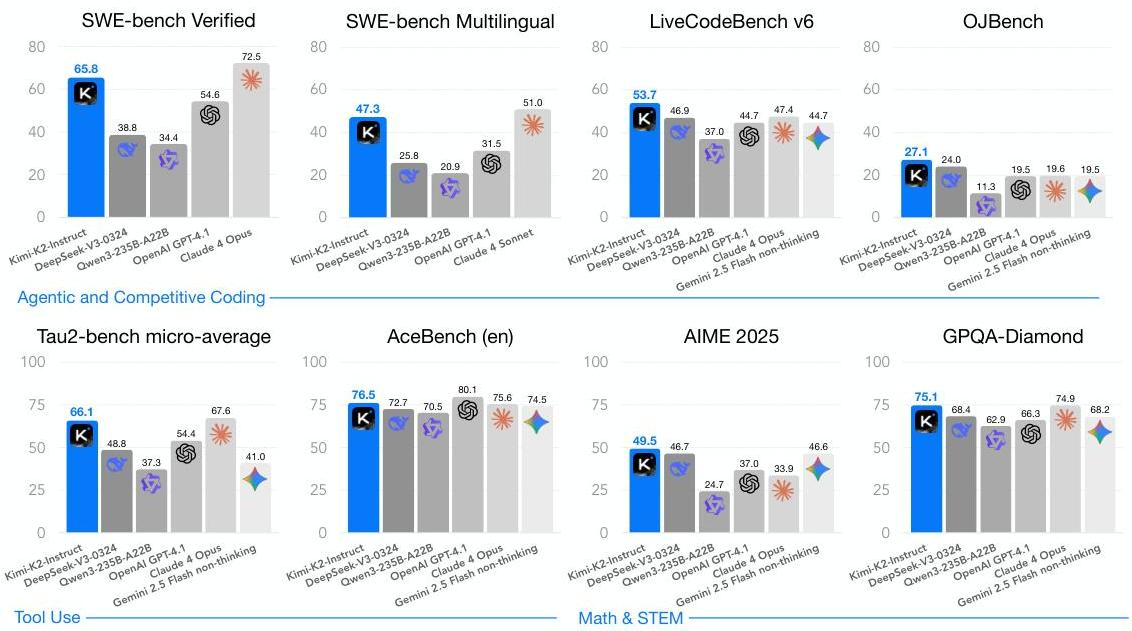

**{
  "image_type": "graph",
  "description": "This image contains a series of bar charts comparing the performance of various AI models across different benchmarks. The benchmarks are categorized into 'Agentic and Competitive Coding' and 'Math & STEM'. Each bar chart represents a specific benchmark, such as SWE-bench Verified, SWE-bench Multilingual, LiveCodeBench v6, OJBench, Tau2-bench micro-average, AceBench (en), AIME 2025, and GPQA-Diamond. The AI models compared include Kimi-K2-Instruct, DeepSeekV3-0324, Owen3-2535B-A22B, OpenAI GPT-4.1, Claude 4 Opus, Claude 4 Sonnet, and Gemini 2.5 Flash non-thinking. The performance scores for each model are displayed on the y-axis, with higher scores indicating better performance. The charts show that different models perform variably across different benchmarks, with Kimi-K2-Instruct generally performing well across most benchmarks."
}**
Figure 1: Kimi K2 main results.2

---

1 Introduction

The development of Large Language Models (LLMs) is undergoing a profound paradigm shift towards *Agentic Intelligence* – the capabilities for models to autonomously perceive, plan, reason, and act within complex and dynamic environments. This transition marks a departure from static imitation learning towards models that actively learn through interactions, acquire new skills beyond their training distribution, and adapt behavior through experiences *[63]*. It is believed that this approach allows an AI agent to go beyond the limitation of static human-generated data, and acquire superhuman capabilities through its own exploration and exploitation. Agentic intelligence is thus rapidly emerging as a defining capability for the next generation of foundation models, with wide-ranging implications across tool use, software development, and real-world autonomy.

Achieving agentic intelligence introduces challenges in both pre-training and post-training. Pre-training must endow models with broad general-purpose priors under constraints of limited high-quality data, elevating token efficiency—learning signal per token—as a critical scaling coefficient. Post-training must transform those priors into actionable behaviors, yet agentic capabilities such as multi-step reasoning, long-term planning, and tool use are rare in natural data and costly to scale. Scalable synthesis of structured, high-quality agentic trajectories, combined with general reinforcement learning (RL) techniques that incorporate preferences and self-critique, are essential to bridge this gap.

In this work, we introduce Kimi K2, a 1.04 trillion-parameter Mixture-of-Experts (MoE) LLM with 32 billion activated parameters, purposefully designed to address the core challenges and push the boundaries of agentic capability. Our contributions span both the pre-training and post-training frontiers:

- We present MuonClip, a novel optimizer that integrates the token-efficient Muon algorithm with a stability-enhancing mechanism called QK-Clip. Using MuonClip, we successfully pre-trained Kimi K2 on 15.5 trillion tokens without a single loss spike.
- We introduce a large-scale agentic data synthesis pipeline that systematically generates tool-use demonstrations via simulated and real-world environments. This system constructs diverse tools, agents, tasks, and trajectories to create high-fidelity, verifiably correct agentic interactions at scale.
- We design a general reinforcement learning framework that combines verifiable rewards (RLVR) with a self-critique rubric reward mechanism. The model learns not only from externally defined tasks but also from evaluating its own outputs, extending alignment from static into open-ended domains.

Kimi K2 demonstrates strong performance across a broad spectrum of agentic and frontier benchmarks. It achieves scores of 66.1 on Tau2-bench, 76.5 on ACEBench (en), 65.8 on SWE-bench Verified, and 47.3 on SWE-bench Multilingual, outperforming most open- and closed-weight baselines under non-thinking evaluation settings, closing the gap with Claude 4 Opus and Sonnet. In coding, mathematics, and broader STEM domains, Kimi K2 achieves 53.7 on LiveCodeBench v6, 27.1 on OJBench, 49.5 on AIME 2025, and 75.1 on GPQA-Diamond, further highlighting its capabilities in general tasks. On the LMSYS Arena leaderboard (July 17, 2025), Kimi K2 ranks as the top 1 open-source model and 5th overall based on over 3,000 user votes.

To spur further progress in Agentic Intelligence, we are open-sourcing our base and post-trained checkpoints, enabling the community to explore, refine, and deploy agentic intelligence at scale.

## 2 Pre-training

The base model of Kimi K2 is a trillion-parameter mixture-of-experts (MoE) transformer *[72]* model, pre-trained on 15.5 trillion high-quality tokens. Given the increasingly limited availability of high-quality human data, we posit that token efficiency is emerging as a critical coefficient in the scaling of large language models. To address this, we introduce a suite of pre-training techniques explicitly designed for maximizing token efficiency. Specifically, we employ the token-efficient Muon optimizer *[33, 46]* and mitigate its training instabilities through the introduction of QK-Clip. Additionally, we incorporate synthetic data generation to further squeeze the intelligence out of available high-quality tokens. The model architecture follows an ultra-sparse MoE with multi-head latent attention (MLA) similar to DeepSeek-V3 *[10]* , derived from empirical scaling law analysis. The underlying infrastructure is built to optimize both training efficiency and research efficiency.

---

2.1 MuonClip: Stable Training with Weight Clipping

We train Kimi K2 using the token-efficient Muon optimizer *[33]*, incorporating weight decay and consistent update RMS scaling *[46]*. Experiments in our previous work Moonlight *[46]* show that, under the same compute budget and model size — and therefore the same amount of training data — Muon substantially outperforms AdamW *[36, 48]*, making it an effective choice for improving token efficiency in large language model training.

#### Training instability when scaling Muon

Despite its efficiency, scaling up Muon training reveals a challenge: training instability due to exploding attention logits, an issue that occurs more frequently with Muon but less with AdamW in our experiments. Existing mitigation strategies are insufficient. For instance, logit soft-cap *[69]* directly clips the attention logits, but the dot products between queries and keys can still grow excessively before capping is applied. On the other hand, Query-Key Normalization (QK-Norm) *[11, 81]* is not applicable to multi-head latent attention (MLA), because its Key matrices are not fully materialized during inference.

#### Taming Muon with QK-Clip

To address this issue, we propose a novel weight-clipping mechanism *QK-Clip* to explicitly constrain attention logits. QK-Clip works by rescaling the query and key projection weights post-update to bound the growth of attention logits.

Let the input representation of a transformer layer be $\mathbf{X}$. For each attention head $h$, its query, key, and value projections are computed as

$\mathbf{Q}^{h}=\mathbf{X}\mathbf{W}_{q}^{h},\quad\mathbf{K}^{h}=\mathbf{X}\mathbf{W}_{k}^{h},\quad\mathbf{V}^{h}=\mathbf{X}\mathbf{W}_{v}^{h}.$

where $\mathbf{W}_{q},\mathbf{W}_{k},\mathbf{W}_{v}$ are model parameters. The attention output is:

$\mathbf{O}^{h}=\operatorname{softmax}\left(\frac{1}{\sqrt{d}}\mathbf{Q}^{h}\mathbf{K}^{h\top}\right)\mathbf{V}^{h}.$

We define the max logit, a per-head scalar, as the maximum input to softmax in this batch $B$:

$S_{\max}^{h}=\frac{1}{\sqrt{d}}\max_{\mathbf{X}\in B}\max_{i,j}\mathbf{Q}_{i}^{h}\mathbf{K}_{j}^{h\top}$

where $i,j$ are indices of different tokens in a training sample $\mathbf{X}$.

The core idea of QK-Clip is to rescale $\mathbf{W}_{k},\mathbf{W}_{q}$ whenever $S_{\max}^{h}$ exceeds a target threshold $\tau$. Importantly, this operation does not alter the forward/backward computation in the current step — we merely use the max logit as a guiding signal to determine the strength to control the weight growth.

A naïve implementation clips all heads at the same time:

$\mathbf{W}_{q}^{h}\leftarrow\gamma^{\alpha}\mathbf{W}_{q}^{h}\qquad\mathbf{W}_{k}^{h}\leftarrow\gamma^{1-\alpha}\mathbf{W}_{k}^{h}$

where $\gamma=\min(1,\tau/S_{\max})$ with $S_{\max}=\max_{h}S_{\max}^{h}$, and $\alpha$ is a balancing parameter typically set to $0.5$, applying equal scaling to queries and keys.

However, we observe that in practice, only a small subset of heads exhibit exploding logits. In order to minimize our intervention on model training, we determine a per-head scaling factor $\gamma_{h}=\min(1,\tau/S_{\max}^{h})$, and opt to apply per-head QK-Clip. Such clipping is straightforward for regular multi-head attention (MHA). For MLA, we apply clipping only on unshared attention head components:

- $\mathbf{q}^{C}$ and $\mathbf{k}^{C}$ (head-specific components): each scaled by $\sqrt{\gamma_{h}}$
- $\mathbf{q}^{R}$ (head-specific rotary): scaled by $\gamma_{h}$,
- $\mathbf{k}^{R}$ (shared rotary): left untouched to avoid effect across heads.

#### MuonClip: The New Optimizer

We integrate Muon with weight decay, consistent RMS matching, and QK-Clip into a single optimizer, which we refer to as MuonClip (see Algorithm 1).

We demonstrate the effectiveness of MuonClip from several scaling experiments. First, we train a mid-scale 9B activated and 53B total parameters Mixture-of-Experts (MoE) model using the vanilla Muon. As shown in Figure 2 (Left), we observe that the maximum attention logits quickly exceed a magnitude of 1000, showing that attention logits explosion is already evident in Muon training to this scale. Max logits at this level usually result in instability during training, including significant loss spikes and occasional divergence.

---

Kimi K2

TECHNICAL REPORT

Algorithm 1 MuonClip Optimizer
1: for each training step  $t$  do
2: // 1. Muon optimizer step
3: for each weight  $\mathbf{W} \in \mathbb{R}^{n \times m}$  do
4:  $\mathbf{M}_t = \mu \mathbf{M}_{t-1} + \mathbf{G}_t$ $\triangleright \mathbf{M}_0 = \mathbf{0}, \mathbf{G}_t$  is the grad of  $\mathbf{W}_t, \mu$  is momentum
5:  $\mathbf{O}_t = \text{Newton-Schulz}(\mathbf{M}_t) \cdot \sqrt{\max(n, m)} \cdot 0.2$ $\triangleright \text{Match Adam RMS}$
6:  $\mathbf{W}_t = \mathbf{W}_{t-1} - \eta(\mathbf{O}_t + \lambda \mathbf{W}_{t-1})$ $\triangleright \text{learning rate } \eta$ , weight decay  $\lambda$
7: end for
8: // 2. QK-Clip
9: for each attention head  $h$  in every attention layer of the model do
10: Obtain  $S_{\max}^h$  already computed during forward
11: if  $S_{\max}^h &gt; \tau$  then
12:  $\gamma \gets \tau / S_{\max}^h$
13:  $\mathbf{W}_{qc}^h \gets \mathbf{W}_{qc}^h \cdot \sqrt{\gamma}$
14:  $\mathbf{W}_{kc}^h \gets \mathbf{W}_{kc}^h \cdot \sqrt{\gamma}$
15:  $\mathbf{W}_{qr}^h \gets \mathbf{W}_{qr}^h \cdot \gamma$
16: end if
17: end for
18: end for

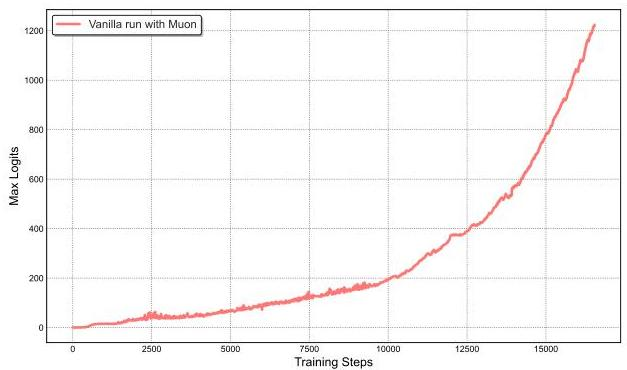

**{
  "image_type": "graph",
  "description": "This graph shows the relationship between training steps and max logits in a machine learning model run with Muon. The x-axis represents the number of training steps, ranging from 0 to 17500, while the y-axis represents the max logits, ranging from 0 to 1200. The data series, labeled 'Vanilla run with Muon,' shows a trend where the max logits increase gradually at first and then more rapidly as the number of training steps increases, indicating an exponential growth pattern."
}**
Figure 2: Left: During a mid-scale training run, attention logits rapidly exceed 1000, which could lead to potential numerical instabilities and even training divergence. Right: Maximum logits for Kimi K2 with MuonClip and  $\tau = 100$  over the entire training run. The max logits rapidly increase to the capped value of 100, and only decay to a stable range after approximately  $30\%$  of the training steps, demonstrating the effective regulation effect of QK-Clip.

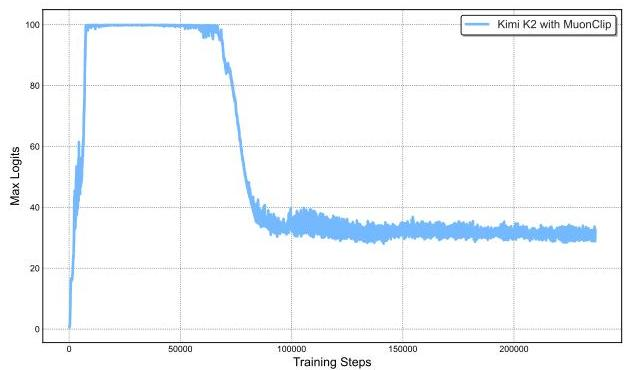

**{
  "image_type": "graph",
  "description": "This graph shows the performance of the Kimi K2 model with MuonClip over training steps. The x-axis represents the number of training steps, ranging from 0 to 200,000. The y-axis represents the max logits, ranging from 0 to 100. The graph shows a sharp increase in max logits initially, reaching a peak and then experiencing a significant drop around the 50,000 training steps mark. After the drop, the max logits stabilize and fluctuate at a lower level for the remainder of the training steps."
}**

Next, we demonstrate that QK-Clip does not degrade model performance and confirm that the MuonClip optimizer preserves the optimization characteristics of Muon without adversely affecting the loss trajectory. A detailed discussion of the experiment designs and findings is provided in the Appendix D.

Finally, we train Kimi K2, a large-scale MoE model, using MuonClip with  $\tau = 100$  and monitor the maximum attention logits throughout the training run (Figure 2 (Right)). Initially, the logits are capped at 100 due to QK-Clip. Over the course of training, the maximum logits gradually decay to a typical operating range without requiring any adjustment to  $\tau$ . Importantly, the training loss remains smooth and stable, with no observable spikes, as shown in Figure 3, validating that MuonClip provides robust and scalable control over attention dynamics in large-scale language model training.

# 2.2 Pre-training Data: Improving Token Utility with Rephrasing

Token efficiency in pre-training refers to how much performance improvement is achieved for each token consumed during training. Increasing token utility—the effective learning signal each token contributes—enhances the per-token impact on model updates, thereby directly improving token efficiency. This is particularly important when the supply of high-quality tokens is limited and must be maximally leveraged. A naive approach to increasing token utility is through repeated exposure to the same tokens, which can lead to overfitting and reduced generalization.

---

Kimi K2

TECHNICAL REPORT

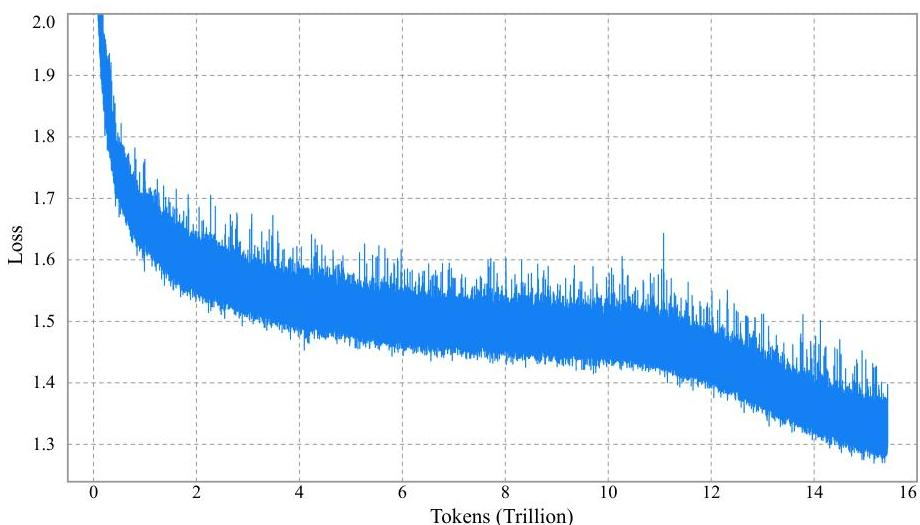

**{
  "image_type": "graph",
  "description": "This graph shows the loss over the number of tokens (in trillions) processed. The y-axis represents the loss, while the x-axis represents the number of tokens. The graph indicates a decreasing trend in loss as the number of tokens increases, with some fluctuations."
}**
Figure 3: Per-step training loss curve of Kimi K2, without smoothing or sub-sampling. It shows no spikes throughout the entire training process. Note that we omit the very beginning of training for clarity.

A key advancement in the pre-training data of Kimi K2 over Kimi K1.5 is the introduction of a synthetic data generation strategy to increase token utility. Specifically, a carefully designed rephrasing pipeline is employed to amplify the volume of high-quality tokens without inducing significant overfitting. In this report, we describe two domain-specialized rephrasing techniques—targeted respectively at the Knowledge and Mathematics domains—that enable this controlled data augmentation.

Knowledge Data Rephrasing Pre-training on natural, knowledge-intensive text presents a trade-off: a single epoch is insufficient for comprehensive knowledge absorption, while multi-epoch repetition yields diminishing returns and increases the risk of overfitting. To improve the token utility of high-quality knowledge tokens, we propose a synthetic rephrasing framework composed of the following key components:

- Style- and perspective-diverse prompting: To enhance linguistic diversity while maintaining factual integrity, we apply a range of carefully engineered prompts. These prompts guide a large language model to generate faithful rephrasings of the original texts in varied styles and from different perspectives.
- Chunk-wise autoregressive generation: To preserve global coherence and avoid information loss in long documents, we adopt a chunk-based autoregressive rewriting strategy. Texts are divided into segments, rephrased individually, and then stitched back together to form complete passages. This method mitigates implicit output length limitations that typically exist with LLMs. An overview of this pipeline is presented in Figure 4.
- Fidelity verification: To ensure consistency between original and rewritten content, we perform fidelity checks that compare the semantic alignment of each rephrased passage with its source. This serves as an initial quality control step prior to training.

We compare data rephrasing with multi-epoch repetition by testing their corresponding accuracy on SimpleQA. We experiment with an early checkpoint of K2 and evaluate three training strategies: (1) repeating the original dataset for 10 epochs, (2) rephrasing the data once and repeating it for 10 epochs, and (3) rephrasing the data 10 times with a single training pass. As shown in Table 1, the accuracy consistently improves across these strategies, demonstrating the efficacy of our rephrasing-based augmentation. We extended this method to other large-scale knowledge corpora and observed similarly encouraging results, and each corpora is rephrased at most twice.

Table 1: SimpleQA Accuracy under three rephrasing-epoch configurations

|  # Rephrasings | # Epochs | SimpleQA Accuracy  |
| --- | --- | --- |
|  0 (raw wiki-text) | 10 | 23.76  |
|  1 | 10 | 27.39  |
|  10 | 1 | 28.94  |

---

Kimi K2

TECHNICAL REPORT

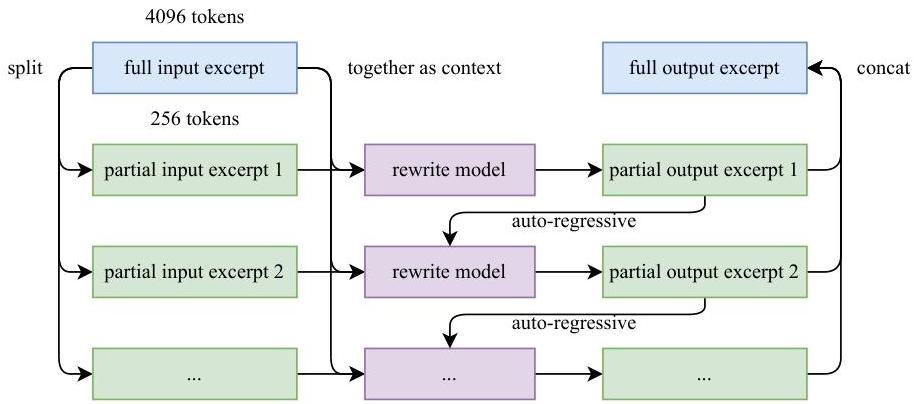

**{
  "image_type": "graph",
  "description": "This diagram illustrates a process of splitting a large input text into smaller excerpts, processing them through a rewrite model, and then combining the outputs. The full input excerpt of 4096 tokens is split into multiple partial input excerpts of 256 tokens each. Each partial input excerpt is processed by a rewrite model to generate a corresponding partial output excerpt. The process is auto-regressive, meaning each step depends on the previous output. Finally, all partial output excerpts are concatenated to form the full output excerpt."
}**
Figure 4: Auto-regressive chunk-wise rephrasing pipeline for long input excerpts. The input is split into smaller chunks with preserved context, rewritten sequentially, and then concatenated into a full rewritten passage.

Mathematics Data Rephrasing To enhance mathematical reasoning capabilities, we rewrite high-quality mathematical documents into a "learning-note" style, following the methodology introduced in SwallowMath [15]. In addition, we increased data diversity by translating high-quality mathematical materials from other languages into English.

Although initial experiments with rephrased subsets of our datasets show promising results, the use of synthetic data as a strategy for continued scaling remains an active area of investigation. Key challenges include generalizing the approach to diverse source domains without compromising factual accuracy, minimizing hallucinations and unintended toxicity, and ensuring scalability to large-scale datasets.

Pre-training Data Overall The Kimi K2 pre-training corpus comprises 15.5 trillion tokens of curated, high-quality data spanning four primary domains: Web Text, Code, Mathematics, and Knowledge. Most data processing pipelines follow the methodologies outlined in Kimi K1.5 [35]. For each domain, we performed rigorous correctness and quality validation and designed targeted data experiments to ensure the curated dataset achieved both high diversity and effectiveness.

# 2.3 Model Architecture

Kimi K2 is a 1.04 trillion-parameter Mixture-of-Experts (MoE) transformer model with 32 billion activated parameters. The architecture follows a similar design to DeepSeek-V3 [10], employing Multi-head Latent Attention (MLA) [44] as the attention mechanism, with a model hidden dimension of 7168 and an MoE expert hidden dimension of 2048. Our scaling law analysis reveals that continued increases in sparsity yield substantial performance improvements, which motivated us to increase the number of experts to 384, compared to 256 in DeepSeek-V3. To reduce computational overhead during inference, we cut the number of attention heads to 64, as opposed to 128 in DeepSeek-V3. Table 2 presents a detailed comparison of architectural parameters between Kimi K2 and DeepSeek-V3.

Table 2: Architectural comparison between Kimi K2 and DeepSeek-V3

|   | DeepSeek-V3 | Kimi K2 | Δ  |
| --- | --- | --- | --- |
|  #Layers | 61 | 61 | =  |
|  Total Parameters | 671B | 1.04T | ↑54%  |
|  Activated Parameters | 37B | 32.6B | ↓13%  |
|  Experts (total) | 256 | 384 | ↑50%  |
|  Experts Active per Token | 8 | 8 | =  |
|  Shared Experts | 1 | 1 | =  |
|  Attention Heads | 128 | 64 | ↓50%  |
|  Number of Dense Layers | 3 | 1 | ↓67%  |
|  Expert Grouping | Yes | No | -  |

---

Kimi K2

TECHNICAL REPORT

Sparsity Scaling Law We develop a sparsity scaling law tailored for the Mixture-of-Experts (MoE) model family using Muon. Sparsity is defined as the ratio of the total number of experts to the number of activated experts. Through carefully controlled small-scale experiments, we observe that — under a fixed number of activated parameters (i.e., constant FLOPs) — increasing the total number of experts (i.e., increasing sparsity) consistently lowers both the training and validation loss, thereby enhancing overall model performance (Figure 5). Concretely, under the compute-optimal sparsity scaling law, achieving the same validation loss of 1.5, sparsity 48 reduces FLOPs by  $1.69 \times$ ,  $1.39 \times$ , and  $1.15 \times$  compared to sparsity levels 8, 16, and 32, respectively. Though increasing sparsity leads to better performance, this gain comes with increased infrastructure complexity. To balance model performance with cost, we adopt a sparsity of 48 for Kimi K2, activating 8 out of 384 experts per forward pass.

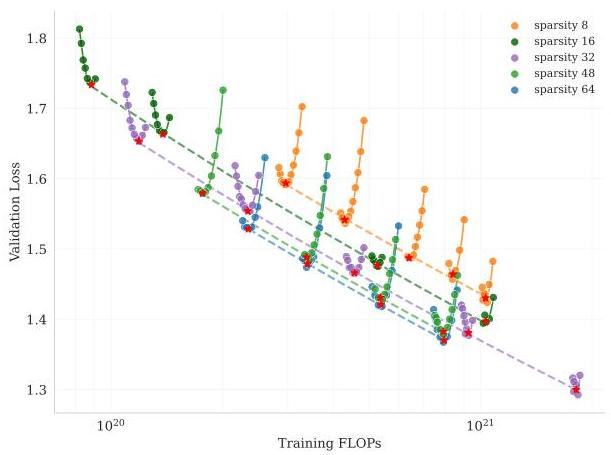

**{
  "image_type": "graph",
  "description": "This graph shows the relationship between Training FLOPs (Floating Point Operations) and Validation Loss for different levels of sparsity in a neural network. The x-axis represents the Training FLOPs on a logarithmic scale, while the y-axis represents the Validation Loss. Different colors and markers represent different sparsity levels: sparsity 8 (orange), sparsity 16 (green), sparsity 32 (purple), sparsity 48 (red), and sparsity 64 (blue). Each data point corresponds to a specific training configuration, and the dashed lines indicate trends for each sparsity level. The graph suggests that as the number of Training FLOPs increases, the Validation Loss generally decreases, with varying rates of improvement depending on the sparsity level."
}**
Figure 5: Sparsity Scaling Law. Increasing sparsity leads to improved model performance. We fixed the number of activated experts to 8 and the number of shared experts to 1, and varied the total number of experts, resulting in models with different sparsity levels.

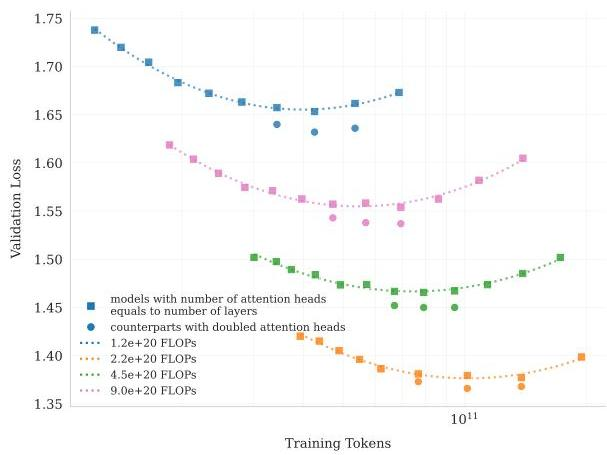

**{
  "image_type": "graph",
  "description": "This graph shows the relationship between the number of training tokens and validation loss for different models. The x-axis represents the number of training tokens on a logarithmic scale, while the y-axis represents the validation loss. The graph includes multiple data series distinguished by different markers and colors. The blue squares and circles represent models with the number of attention heads equal to the number of layers and their counterparts with doubled attention heads, respectively. The orange, green, pink, and blue data series represent models with different computational budgets (1.2e+20 FLOPs, 2.2e+20 FLOPs, 4.5e+20 FLOPs, and 9.0e+20 FLOPs, respectively). The dotted lines indicate trends for each data series. The graph shows that as the number of training tokens increases, the validation loss generally decreases, with variations depending on the model configuration and computational budget."
}**
Figure 6: Scaling curves for models with number of attention heads equals to number of layers and their counterparts with doubled attention heads. Doubling the number of attention heads leads to a reduction in validation loss of approximately  $0.5\%$  to  $1.2\%$ .

Number of Attention Heads DeepSeek-V3 [10] sets the number of attention heads to roughly twice the number of model layers to better utilize memory bandwidth and enhance computational efficiency. However, as the context length increases, doubling the number of attention heads leads to significant inference overhead, reducing efficiency at longer sequence lengths. This becomes a major limitation in agentic applications, where efficient long context processing is essential. For example, with a sequence length of 128k, increasing the number of attention heads from 64 to 128, while keeping the total expert count fixed at 384, leads to an  $83\%$  increase in inference FLOPs. To evaluate the impact of this design, we conduct controlled experiments comparing configurations where the number of attention heads equals the number of layers against those with double number of heads, under varying training FLOPs. Under iso-token training conditions, we observe that doubling the attention heads yields only modest improvements in validation loss (ranging from  $0.5\%$  to  $1.2\%$ ) across different compute budgets (Figure 6). Given that sparsity 48 already offers strong performance, the marginal gains from doubling attention heads do not justify the inference cost. Therefore we choose to 64 attention heads.

# 2.4 Training Infrastructure

# 2.4.1 Compute Cluster

Kimi K2 was trained on a cluster equipped with NVIDIA H800 GPUs. Each node in the H800 cluster contains 2 TB RAM and 8 GPUs connected by NVLink and NVSwitch within nodes. Across different nodes,  $8 \times 400$  Gbps RoCE interconnects are utilized to facilitate communications.

# 2.4.2 Parallelism for Model Scaling

Training of large language models often progresses under dynamic resource availability. Instead of optimizing one parallelism strategy that's only applicable under specific amount of resources, we pursue a flexible strategy that allows Kimi K2 to be trained on any number of nodes that is a multiple of 32. Our strategy leverages a combination of 16-way

---

K Kimi K2

TECHNICAL REPORT

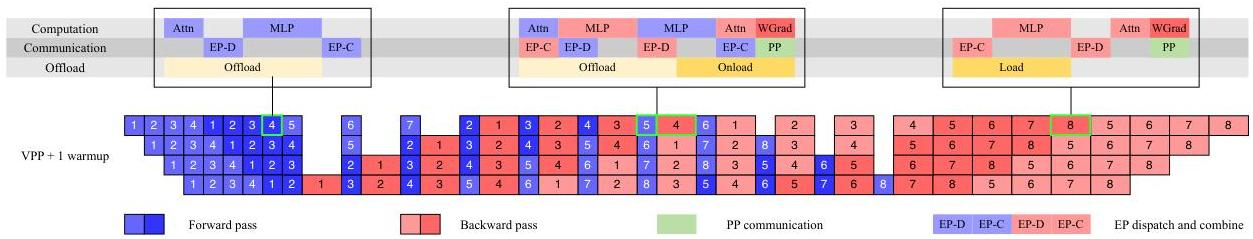

**{
  "image_type": "image",
  "description": "This image depicts a timeline of computational, communication, and offloading processes in a machine learning pipeline. The timeline is divided into three main categories: Computation, Communication, and Offload. Each category is further divided into specific tasks such as Attention (Attn), Multi-Layer Perceptron (MLP), Error Propagation Dispatch (EP-D), Error Propagation Combine (EP-C), Weight Gradient (WGrad), and Pipeline Parallel (PP). The timeline is segmented into different stages, each marked by a number indicating the sequence of operations. The color coding indicates different phases: blue for forward pass, red for backward pass, and green for PP communication. The image illustrates the sequence and interaction of these processes, highlighting the complexity and coordination required in a machine learning pipeline."
}**
Figure 7: Computation, communication and offloading overlapped in different PP phases.

Pipeline Parallelism (PP) with virtual stages [28, 53, 38, 57, 47, 21], 16-way Expert Parallelism (EP) [39], and ZeRO-1 Data Parallelism [60].

Under this setting, storing the model parameters in BF16 and their gradient accumulation buffer in FP32 requires approximately 6 TB of GPU memory, distributed over a model-parallel group of 256 GPUs. Placement of optimizer states depends on the training configurations. When the total number of training nodes is large, the optimizer states are distributed, reducing its per-device memory footprint to a negligible level. When the total number of training nodes is small (e.g., 32), we can offload some optimizer states to CPU.

This approach allows us to reuse an identical parallelism configuration for both small- and large-scale experiments, while letting each GPU hold approximately 30 GB of GPU memory for all states. The rest of the GPU memory are used for activations, as described in Sec. 2.4.3. Such a consistent design is important for research efficiency, as it simplifies the system and substantially accelerates experimental iteration.

EP communication overlap with interleaved 1F1B By increasing the number of warm-up micro-batches, we can overlap EP all-to-all communication with computation under the standard interleaved 1F1B schedule [21, 53]. In comparison, DualPipe [10] doubles the memory required for parameters and gradients, necessitating an increase in parallelism to compensate. Increasing PP introduces more bubbles, while increasing EP, as discussed below, incurs higher overhead. The additional costs are prohibitively high for training a large model with over 1 trillion parameters and thus we opted not to use DualPipe.

However, interleaved 1F1B splits the model into more stages, introducing non-trivial PP communication overhead. To mitigate this cost, we decouple the weight-gradient computation from each micro-batch's backward pass and execute it in parallel with the corresponding PP communication. Consequently, all PP communications can be effectively overlapped except for the warm-up phase.

Smaller EP size To ensure full computation-communication overlap during the 1F1B stage, the reduced attention computation time in K2 (which has 64 attention heads compared to 128 heads in DeepSeek-V3) necessitates minimizing the time of EP operations. This is achieved by adopting the smallest feasible EP parallelization strategy, specifically  $\mathrm{EP} = 16$ . Utilizing a smaller EP group also relaxes expert-balance constraints, allowing for near-optimal speed to be achieved without further tuning.

# 2.4.3 Activation Reduction

After reserving space for parameters, gradient buffers, and optimizer states, the remaining GPU memory on each device is insufficient to hold the full MoE activations. To ensure the activation memory fits within the constraints, especially for the initial pipeline stages that accumulate the largest activations during the 1F1B warm-up phase, the following techniques are employed.

Selective recomputation Recomputation is applied to inexpensive, high-footprint stages, including LayerNorm, SwiGLU, and MLA up-projections [10]. Additionally, MoE down-projections are recomputed during training to further reduce activation memory. While optional, this recomputation maintains adequate GPU memory, preventing crashes caused by expert imbalance in early training stages.

FP8 storage for insensitive activations Inputs of MoE up-projections and SwiGLU are compressed to FP8-E4M3 in  $1 \times 128$  tiles with FP32 scales. Small-scale experiments show no measurable loss increase. Due to potential risks of performance degradation that we observed during preliminary study, we do not apply FP8 in computation.

In [49]:
# Display (just first page)
final_markdown = process_saved_ocr_json("RAG/OCR/responses.json", range=[0, 1])
display(Markdown(final_markdown))

In [ ]:
# authors are on the last page:
final_page = process_saved_ocr_json("RAG/OCR/responses.json")

## Document Summary
**{
  "language": "en",
  "summary": "The document is a technical report for Kimi K2, detailing various aspects of its development and performance. It includes an appendix listing authors and their contributions, a section on token templates for tool calling, evaluation details of Kimi-K2-Instruct on various benchmarks, and discussions on technical aspects such as the QK-Clip method and engine switching pipeline for RL training. The report highlights Kimi-K2-Instruct's superior performance on coding, tool use, math, STEM, and general tasks, as well as its capabilities in handling open-ended evaluations and factuality tasks. It also addresses the model's strengths and potential limitations, such as the tendency to overstate certainty in ambiguous contexts.",
  "authors": [
    "Yifan Bai",
    "Yiping Bao",
    "Guanduo Chen",
    "Jiahao Chen",
    "Ningxin Chen",
    "Ruijue Chen",
    "Yanru Chen",
    "Yuankun Chen",
    "Yutian Chen",
    "Zhuofu Chen*",
    "Ji

### 2.2 Parsing Metadata

An important aspect of a RAG system is the metadata: we want to present data to the user with the given source, probably the page, images and tables if we parsed them... and so on.

In [50]:
def load_ocr_json(json_path: str, range: list[int] = None) -> list[dict]:
    """
    Loads the saved JSON list of OCR responses.

    Args:
        json_path: Path to the JSON file containing OCR responses
        range: Optional range [start, end] to slice the responses list

    Returns:
        List of OCR response dictionaries
    """
    with open(json_path, "r") as f:
        responses_list = json.load(f)
    
    # Return sliced or full list
    return responses_list[range[0]:range[1]] if range is not None else responses_list

In [51]:
# Load all responses
all_responses = load_ocr_json("RAG/OCR/responses.json")
# Access the data
for resp in all_responses:
    print(resp["document_annotation"])

{
  "language": "en",
  "summary": "The document introduces Kimi K2, a Mixture-of-Experts (MoE) large language model with 32 billion activated parameters and 1 trillion total parameters. It highlights the MuonClip optimizer, which improves upon the Muon optimizer with a novel QK-clip technique to enhance training stability and token efficiency. Kimi K2 was pre-trained on 15.5 trillion tokens and underwent a multi-stage post-training process, including a large-scale agentic data synthesis pipeline and joint reinforcement learning. The model demonstrates state-of-the-art performance across various benchmarks, excelling in agentic capabilities and tasks such as coding, mathematics, and reasoning. The document also discusses the technical aspects of the model's architecture, training infrastructure, and the strategies used to optimize training efficiency and performance.",
  "authors": [
    "Kimi Team"
  ]
}
{
  "language": "en",
  "summary": "The document discusses the technical aspects 

This is a part of our metadata. Since we split the document into several parts, we may want to fuse together all the author fields, but maybe get the summary only from the first part (where the abstract is). Another part is the page, of the document, but that is easy to retrieve.
 
But another important part of our metadata is the images and the tables. 

We want to replace images and tables with a textual description for our RAG. Then we'll map to the actual base64/html encoding with metadata.  

In [ ]:
first_img = all_responses[0]["pages"][0]["images"][0]
print(first_img['id'])
print(first_img['image_annotation'])

img-0.jpeg
{
  "image_type": "graph",
  "description": "This image contains a series of bar charts comparing the performance of various AI models across different benchmarks. The benchmarks are categorized into 'Agentic and Competitive Coding' and 'Math & STEM'. Each bar chart represents a specific benchmark, such as SWE-bench Verified, SWE-bench Multilingual, LiveCodeBench v6, OJBench, Tau2-bench micro-average, AceBench (en), AIME 2025, and GPQA-Diamond. The AI models compared include Kimi-K2-Instruct, DeepSeekV3-0324, Owen3-2535B-A22B, OpenAI GPT-4.1, Claude 4 Opus, Claude 4 Sonnet, and Gemini 2.5 Flash non-thinking. The performance scores for each model are displayed on the y-axis, with higher scores indicating better performance. The charts show that different models perform variably across different benchmarks, with Kimi-K2-Instruct generally performing well across most benchmarks."
}


It will be easy to parse images and swap them with their description because Mistral provides the annotation for us. 

But how about tables?